# Evaluate Trends in misinformation on Twitter in the run-up to the 2020 US Presidential Elections

# Team Members
Abhishek Bais, Samer Baslan, Jimmy Liang, Rohan Kumar

# Import packages

In [ ]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import string, collections, unicodedata
import missingno as msno

# Import NLP libraries
import re
import nltk
import json
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Import models, evaluator libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split

# Import location, time libraries
import os
import time
from datetime import datetime, timedelta

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
!pip install langdetect


In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 6.0MB/s 
     |████████████████████████████████| 14.8MB 315kB/s 
     |████████████████████████████████| 6.5MB 44.4MB/s 


In [ ]:
# Mount Google Drive
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Utlity APIs

In [ ]:
# Read in the common word phrases
with open('/content/drive/My Drive/256/256_common_word_phrases.json', 'r') as f:
    phrases_dict = json.load(f)
phrases = phrases_dict['phrases']
phrases

{"'cause": 'because',
 "ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [ ]:
# Stop words for lemma
stop_words = set(stopwords.words('english'))
stop_words.add('https')
stop_words.add('http')

In [ ]:
# Pre-process emojis
def preprocess_emojis(text):
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negative ', text) # Sad
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negative ', text)                  # Weep
    text = re.sub(r'(<3|:\*)', ' positive ', text)                           # Love
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positive ', text)            # Wink
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positive ', text)              # Laughs
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positive ', text) # Smileys
    return text

In [ ]:
# Pre-process tweet
def preprocess_text(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    return text

In [ ]:
# Custom lemmatize and split text into words for ngram visualization
def custom_lemmatize(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  wnl = WordNetLemmatizer()
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stop_words and len(word)>3]

In [ ]:
# Clean the tweet for ngram visualization
def clean_tweet(text):
    preprocess_text(text)
    cleaned_text=""
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    text = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',text)
    words=text.split()
    for word in words:
        if word not in stop_words:
            cleaned_text=cleaned_text+' '+word
    return cleaned_text

In [ ]:
# Custom lemmatize and recreate text for sentiment analysis
def custom_lemmatize_and_join(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  lemmatizer = WordNetLemmatizer()
  word_list = text.split()        
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if not w in stop_words and len(w)>3])   
  return text

In [ ]:
# Pre-process tweet to prepare clean, lemma tweet for sentiment analysis
def preprocess_tweet(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    custom_lemmatize_and_join(text)
    return text

In [ ]:
# Plot word cloud
def generate_word_cloud(stop_words, text):
  plt.figure(figsize=(10,10))
  wordcloud = WordCloud(stopwords=stop_words, 
                      background_color="black", max_words=2500,
                      max_font_size=256, random_state=101,
                      width=1600, height=1600).generate(str(text.dropna()))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

In [ ]:
# Generate date
from matplotlib.ticker import FuncFormatter
def generate_dates(x, pos):
  return dates.num2date(x).strftime('%m-%d')

In [ ]:
# utilities to eatmap for tweet origin, outlet medium and by language
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

# Function to hide axis
def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)
def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

In [ ]:
# Function to plot tweet source
def draw_heatmap(df, this_ax, heat_map_args):
    hm = sns.heatmap(df, ax = this_ax, **heat_map_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

In [ ]:
# Function to plot n-grams
def generate_ngram(ngram_left, ngram_right, title_left, title_right, color_scheme):
  fig, ax=plt.subplots(1,2, figsize=(8,16), 
                       gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})
  if (color_scheme == 0):
    # real vs fake news
    left_color = 'peru'
    right_color = 'teal'
  else:
    # biden vs trump
    left_color = 'blue'
    right_color = 'red'
  
  # left n-gram fake news/ biden
  left_box = ax[0]
  ngram_left[::-1].plot.barh(ax=left_box, color=left_color,**barstyle)
  left_box.yaxis.set_label_position("left")
  left_box.xaxis.tick_top()
  left_box.xaxis.set_label_position("top")
  left_box.xaxis.set_major_formatter(formatterK2)
  left_box.set_xlim([0, 3500])
  left_box.set_xlim(left_box.get_xlim()[::-1])
  left_box.set_xlabel(title_left)
  left_box.set_ylabel('')

  # right n-gram real news/ trump
  right_box = ax[1]
  ngram_right[::-1].plot.barh(ax=right_box, color=right_color,**barstyle)
  right_box.xaxis.tick_top()
  right_box.xaxis.set_label_position("top")
  right_box.xaxis.set_major_formatter(formatterK2)
  right_box.set_xlim([0, 3500])
  right_box.set_xlim(right_box.get_xlim())
  right_box.yaxis.tick_right()
  right_box.set_xlabel(title_right)
  right_box.set_ylabel('')
  plt.show()

In [ ]:
# Function to plot predicted probabilities of real, fake news on test data
def plot_predicted_probabilities(y_pred, col):
  # adjust the font size 
  plt.rcParams['font.size'] = 12

  # plot histogram with 10 bins
  plt.hist(y_pred, bins = 10, color=col)

  # set the title of predicted probabilities
  plt.title('Histogram of predicted probabilities of fake, real news')

  # set the x-axis limit
  plt.xlim(0,1)

  # set the title
  plt.xlabel('Predicted probabilities of fake, real news')
  plt.ylabel('Frequency')

# Training Data Exploration

# Peak at the fake news training dataset

In [ ]:
# Peek at the real news dataset, excluding the first, second column
df_fake_news = pd.read_csv('/content/drive/My Drive/255/datasets/fake_news.csv', ).iloc[:, 2:]
df_fake_news.head(5)

In [ ]:
# Report the number of entries in fake news dataset
df_fake_news.shape

(12999, 18)

In [ ]:
# Inspect the dataset to find missing entries
df_fake_news.isnull().sum()

author                2424
published             0   
title                 680 
text                  46  
language              0   
crawled               0   
site_url              0   
country               176 
domain_rank           4223
thread_title          12  
spam_score            0   
main_img_url          3643
replies_count         0   
participants_count    0   
likes                 0   
comments              0   
shares                0   
type                  0   
dtype: int64

In [ ]:
# Fill columns with missing title with null string
df_fake_news['title'].fillna("", inplace=True)
df_fake_news.isnull().sum()
df_fake_news.shape

(12999, 18)

# Fake News training data exploration

In [ ]:
# Report unique authors of fake news
df_fake_news['author'].value_counts().head(10)

admin                                    247
Alex Ansary                              100
Editor                                   100
Gillian                                  100
Eddy Lavine                              100
Starkman                                 100
Pakalert                                 100
noreply@blogger.com (Alexander Light)    99 
BareNakedIslam                           99 
Dave Hodges                              99 
Name: author, dtype: int64

# Fake news by type 

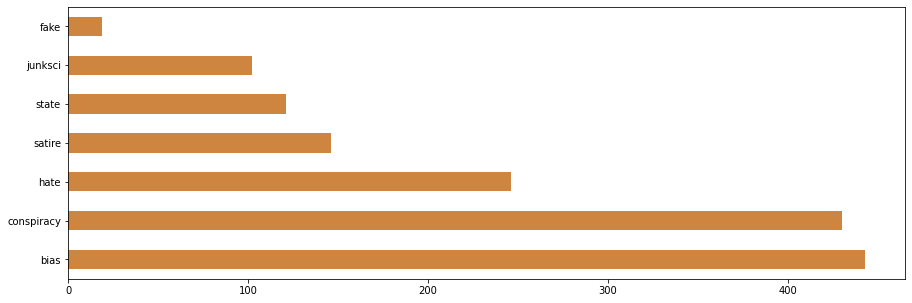

In [ ]:
# Report fake news by type, excluding bs news
plt.figure(figsize=(15,5), edgecolor='b')
df_fake_news[df_fake_news['type'] != 'bs']['type'].value_counts().plot(kind="barh", color='peru')

# Fake News country of origin

Text(0.5, 1.0, 'Top 6 countries fake news originating from')

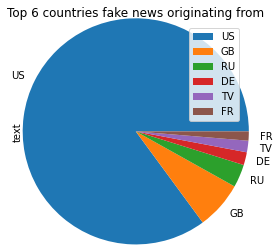

In [ ]:
# Report fake news by type, excluding bs news
sources=pd.DataFrame(df_fake_news.groupby(['country'])['text'].count().sort_values(ascending=False)[:6])
sources.plot(kind = 'pie', x = 'country', y = 'text', radius=1.3)
plt.title("Top 6 countries fake news originating from")

In [ ]:
# Drop entries with null text
# Drop unwanted columns
df_fake_news.dropna(subset=['text'], axis=0, inplace=True)
df_fake_news.drop(['author','country','domain_rank','main_img_url','thread_title'], axis=1, inplace=True)
df_fake_news.reset_index(drop=True, inplace=True)
df_fake_news.isnull().sum()

published             0  
title                 680
text                  0  
language              0  
crawled               0  
site_url              0  
spam_score            0  
replies_count         0  
participants_count    0  
likes                 0  
comments              0  
shares                0  
type                  0  
dtype: int64

# Fake News word cloud

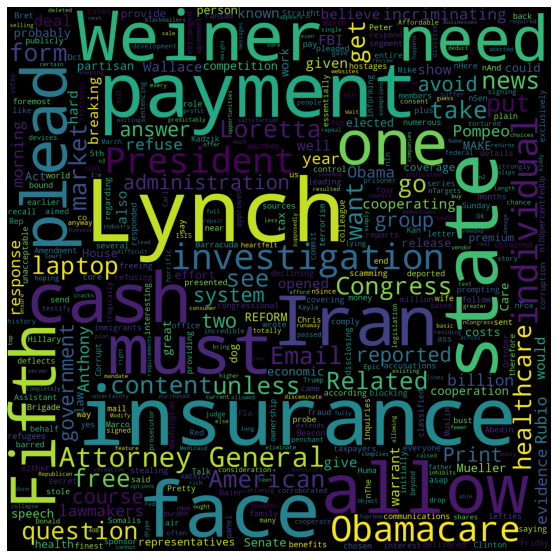

In [ ]:
# Plot the word cloud of fake news content
text=df_fake_news['text']
generate_word_cloud(stop_words, text)

# Fake News unique news sources

Text(0.5, 1.0, 'Publications')

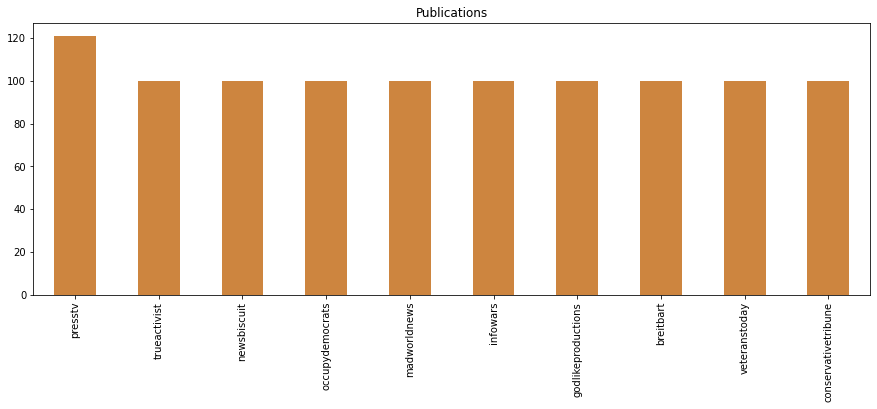

In [ ]:
# Plot sources of fake news
df_fake_news['site_url'] = df_fake_news['site_url'].apply(lambda x:x.split(".")[0])
plt.figure(figsize=(15,5))
df_fake_news['site_url'].value_counts().head(10).plot(kind="bar",color='peru')
plt.title('Publications')

# Peak at the real news training dataset

In [ ]:
# Peek at the real news dataset, excluding the first, second column
df_real_news = pd.read_csv('/content/drive/My Drive/255/datasets/real_news.csv', ).iloc[:, 2:]
df_real_news.head(5)

In [ ]:
# Report the number of real news in dataset
df_real_news.shape

(15712, 9)

In [ ]:
# Inspect the dataset to find missing entries
df_real_news.isnull().sum()

id             0   
title          0   
publication    0   
author         1745
date           0   
year           0   
month          0   
url            4611
content        0   
dtype: int64

In [ ]:
# Drop the columns author, url as they contain missing entries
df_real_news.drop(['author','url'],axis=1, inplace=True)
df_real_news.isnull().sum()
df_real_news.shape

(15712, 7)

# Real News exploration

In [ ]:
# Report the unique sources of real news
df_real_news['publication'].value_counts().head(10)

Reuters            2307
NPR                2014
Washington Post    1886
Guardian           1880
CNN                1624
Atlantic           1558
New York Times     1428
Fox News           1132
National Review    973 
Vox                910 
Name: publication, dtype: int64

# Real News word cloud

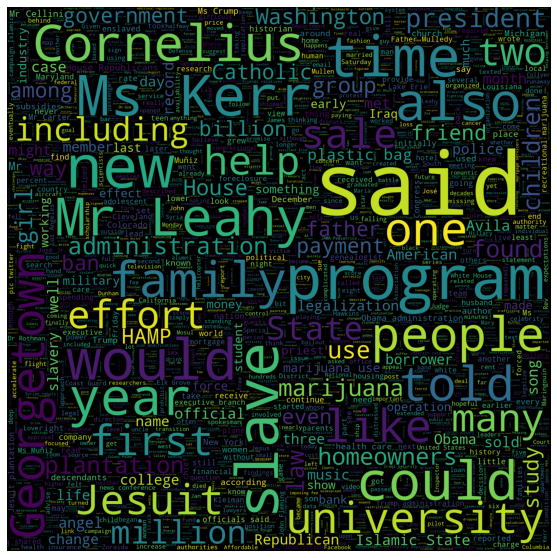

In [ ]:
# Plot the word cloud of real news content
text=df_real_news['content']
generate_word_cloud(stop_words, text)

# Real News unique news sources

Text(0.5, 1.0, 'Publications')

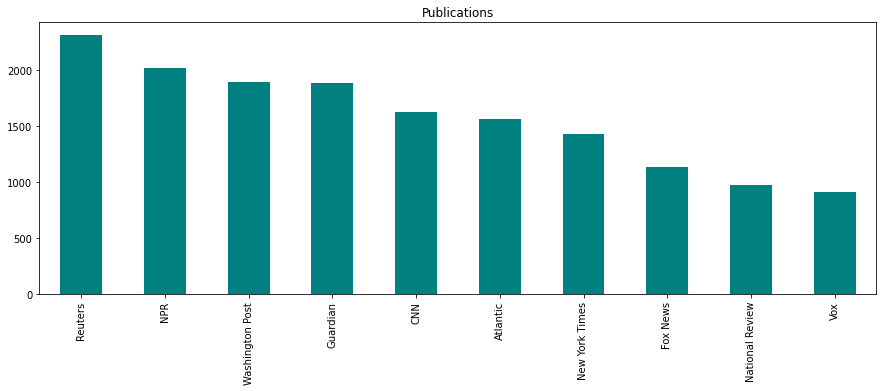

In [ ]:
# Plot the unique news sources
plt.figure(figsize=(15,5))
df_real_news['publication'].value_counts().plot(kind="bar", color='teal')
plt.title('Publications')

# Fake, Real News bi, tri gram

In [ ]:
# Get the text/ content of fake/ real news
text1=df_fake_news['text']
text2=df_real_news['content']

In [ ]:
# Generate bi/tri gram from fake/real news
# Get the words from the text/ content
words1 = custom_lemmatize(''.join(str(text1.apply(clean_tweet).tolist())))
words2 = custom_lemmatize(''.join(str(text2.apply(clean_tweet).tolist())))

# Get the bi/ tri grams from the words
fake_news_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
real_news_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
fake_news_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
real_news_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Plot the bi/tri grams
fake_news_ngrams=pd.concat([fake_news_2ngrams, fake_news_3ngrams])
real_news_ngrams=pd.concat([real_news_2ngrams, real_news_3ngrams])

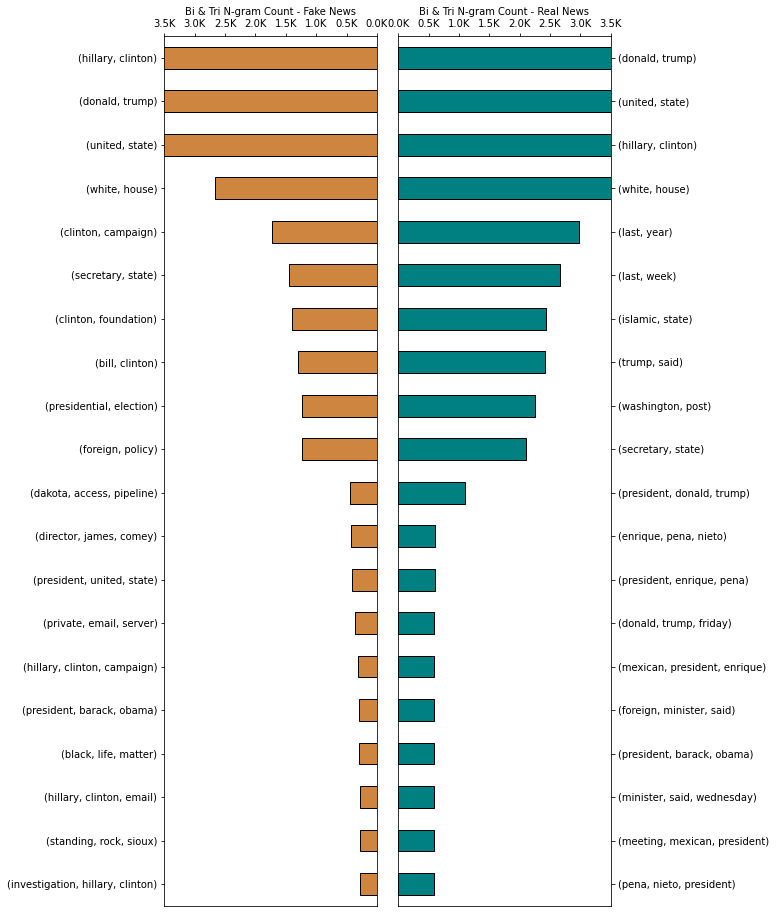

In [ ]:
generate_ngram(fake_news_ngrams, real_news_ngrams, "Bi & Tri N-gram Count - Fake News", "Bi & Tri N-gram Count - Real News", 0)

# Merge real, fake news in prep for data modelling

In [ ]:
# Prune unwanted columns in fake news
# Treat hate, satire, conspiracy, fake news in fake news dataset as fake news
fake_news = df_fake_news[['title', 'text']]
fake_news.dropna(inplace=True)
fake_news.reset_index(drop=True, inplace=True)
fake_news['type'] = 'fake'
fake_news.columns = ['title','tweet','type']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Prune unwanted columns in real news
real_news = df_real_news[['title', 'content']]
real_news.dropna(inplace=True)
real_news.reset_index(drop=True, inplace=True)
real_news['type'] = 'real'
real_news.columns = ['title','tweet','type']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# Prepare clean dataset of real, fake news
all_news = pd.concat([fake_news, real_news])
all_news.reset_index(drop=True, inplace=True)
pd.set_option('display.max_colwidth', 0)
all_news

In [ ]:
# Report real, fake news entries post pre-processing
all_news.shape

(27985, 4)

# Visualize title, content characteristics of fake, real news

In [ ]:
all_news['title_length'] = all_news['title'].apply(len)
all_news['content_length'] = all_news['tweet'].apply(len)
all_news['title_ucase_length'] = all_news['title'].apply(lambda x:len(re.findall('([A-Z])', x)))
all_news['content_ucase_length'] = all_news['tweet'].apply(lambda x:len(re.findall('([A-Z])', x)))
all_news['title_punctuation_length'] = all_news['title'].apply(lambda x:len(re.sub(r'[^\w\s]','',x)))
all_news['content_punctuation_length'] = all_news['tweet'].apply(lambda x:len(re.sub(r'[^\w\s]','',x)))
all_news['tweet'] = all_news['title']+', '+all_news['tweet']
all_news

title  ... content_punctuation_length
0      Muslims BUSTED: They Stole Millions In Gov’t Benefits                                                                          ...  494                      
1      Re: Why Did Attorney General Loretta Lynch Plead The Fifth?                                                                    ...  1736                     
2      BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation                                                           ...  1323                     
3      PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS: "I have voted for Donald J. Trump!" » 100percentfedUp.com  ...  265                      
4      FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com                            ...  2058                     
...                                                                                                    ...                            ...   ...                     
27980  An eavesdropping Uber driver saved his 16-year-old passenger from her pimps, police say                                        ...  4383                     
27981  Plane carrying six people returning from a Cavaliers game disappears over Lake Erie                                            ...  3372                     
27982  After helping a fraction of homeowners expected, Obama’s foreclosure prevention program is finally ending                      ...  6744                     
27983  Yes, this is real: Michigan just banned banning plastic bags                                                                   ...  4035                     
27984  What happened in Washington state after voters legalized recreational marijuana                                                ...  4745                     

[27985 rows x 10 columns]

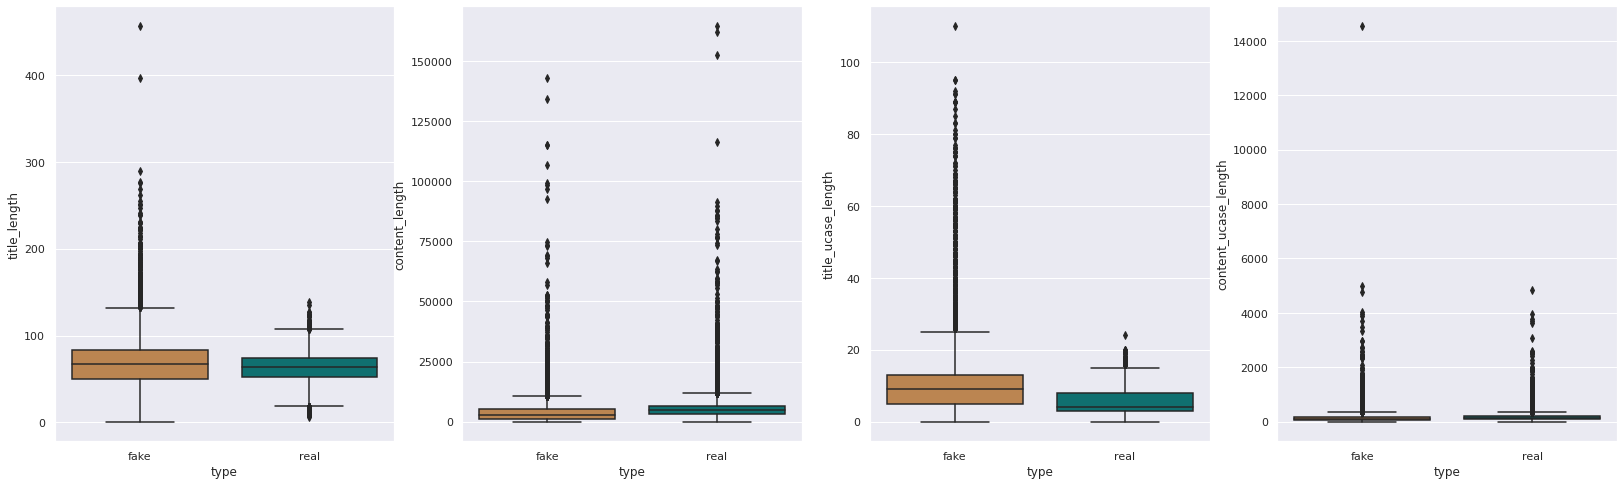

In [ ]:
# Plot the fake, real news characteristics
sns.set(rc={'figure.figsize':(28,8)})
fig, ax = plt.subplots(ncols=4)
my_colors = {"fake": "peru", "real": "teal"}

# Real vs fake news - title length
sns.boxplot(x='type', y='title_length', data=all_news, ax=ax[0],palette=my_colors)

# Real vs fake news - content length
sns.boxplot(x='type', y='content_length', data=all_news, ax=ax[1],palette=my_colors)

# Real vs fake news - title uppercase length
sns.boxplot(x="type", y="title_ucase_length", data=all_news, ax=ax[2],palette=my_colors)

# Real vs fake news - title uppercase length
sns.boxplot(x="type", y="content_ucase_length", data=all_news, ax=ax[3],palette=my_colors)

# Clean and Lemma merged fake, real news

In [ ]:
# Clean, Lemma fake news tweets
all_news['preprocessed_tweet'] = all_news.tweet.apply(preprocess_tweet)

# Test Data Exploration

# Read in tweets referencing Joe Biden and Donald Trump

In [ ]:
# Read in tweets referencing Joe Biden and Donald Trump
df_biden = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
df_trump = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

In [ ]:
# Report the number of entries in biden dataset
df_biden.shape

(776886, 21)

In [ ]:
# Report Biden data
df_biden.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [ ]:
# Inspect biden data for missing entries
df_biden.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     713
user_id                      0
user_name                   18
user_screen_name             0
user_description         82006
user_join_date               0
user_followers_count         0
user_location           233791
lat                     421593
long                    421593
city                    590014
country                 423107
continent               423089
state                   516691
state_code              532277
collected_at                 0
dtype: int64

In [ ]:
# Report the number of entries in trump dataset
df_trump.shape

(970919, 21)

In [ ]:
# Report Trump data
df_trump.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [ ]:
# Inspect trump data for missing entries
df_trump.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     876
user_id                      0
user_name                   16
user_screen_name             0
user_description        101266
user_join_date               0
user_followers_count         0
user_location           294953
lat                     525200
long                    525200
city                    743732
country                 528171
continent               528154
state                   650299
state_code              670494
collected_at                 0
dtype: int64

# Clean, Lemma Biden tweets

In [ ]:
# Clean, Lemma, vectorize the Biden tweets
df_biden['preprocessed_tweet'] = df_biden.tweet.apply(preprocess_tweet)

In [ ]:
# Report original and clean, lemma, stemmed Biden tweets
pd.set_option('display.max_colwidth', 0)
df_biden.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,hunterbiden hunterbidenemails joebiden joebidenmuststepdown enmxwvepm
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,this is how biden made his trumpisnotamerica ip


# Clean, Lemma Trump tweets

In [ ]:
# Clean, Lemma the Trump tweets
df_trump['preprocessed_tweet'] = df_trump.tweet.apply(preprocess_tweet)

In [ ]:
# Report original and clean, lemma, stemmed Trump tweets
pd.set_option('display.max_colwidth', 0)
df_trump.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,usa trump contro facebook twitter coprono biden donaldtrump ceurhe vp jidljoon
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump as student used to hear for years for ten years heard china in and we have and they don know how many we have and asked them how many do we have and they said sir we don know but we have millions like million um what


# Data exploration

# Visualize tweet origin

In [ ]:
# Get the location of the tweet origin
import geopandas as gpd
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point

df_location=pd.concat([df_trump[['lat','long']].copy(),df_biden[['lat','long']].copy()])
df_location=df_location.dropna()
geometry = [Point(xy) for xy in zip(df_location['long'],df_location['lat'])]
geo_df=gpd.GeoDataFrame(df_location, geometry = geometry)

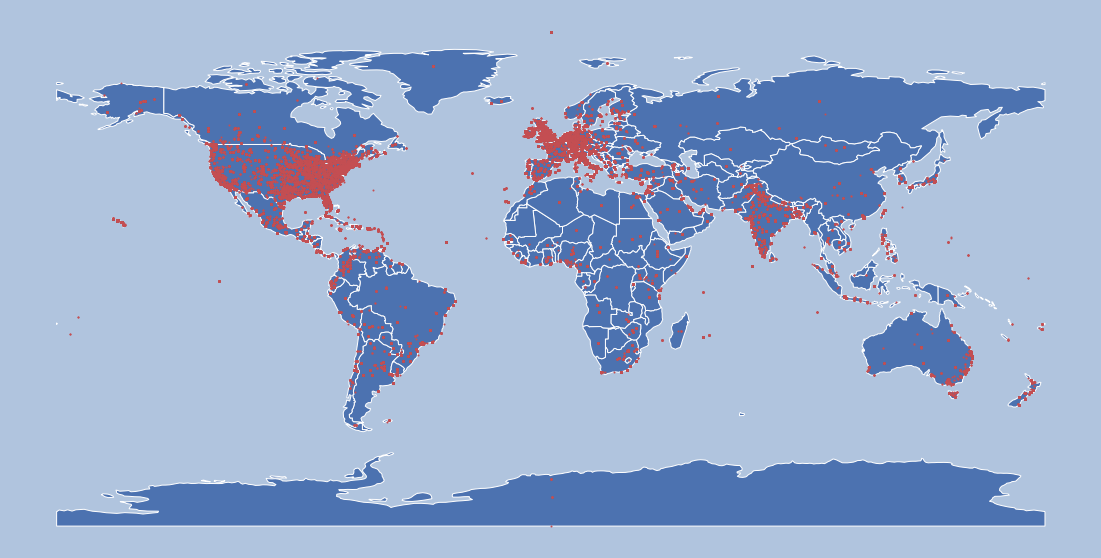

In [ ]:
# Plot the location of the tweet origin
fig, ax = plt.subplots(1,figsize=(20,10), facecolor='lightsteelblue')
world.plot(ax=ax)
geo_df.plot(ax=ax, color='r', markersize=1)
ax.axis('off')
plt.show()

In [ ]:
# Capture tweet time as date time object for time-series analysis
df_biden['collected_at']=pd.to_datetime(df_biden['collected_at'])
df_trump['collected_at']=pd.to_datetime(df_trump['collected_at'])
df_biden['created_at']=pd.to_datetime(df_biden['created_at'])
df_trump['created_at']=pd.to_datetime(df_trump['created_at'])

# Visualize tweet source, platform published and counts

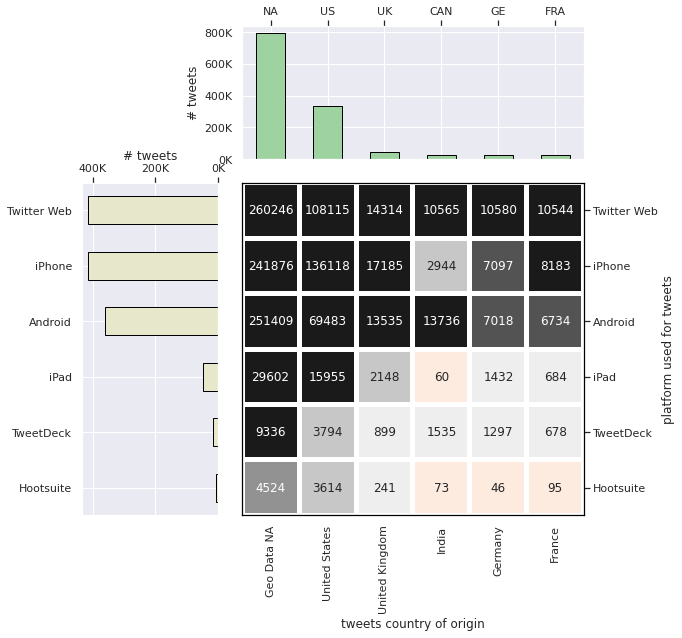

In [ ]:
# Group tweets by country of origin
source_dataframe = pd.concat([df_biden[['source','tweet','country']].copy(),df_trump[['source','tweet','country']].copy()])
source_dataframe['country'].replace({'United States of America':'United States'}, inplace=True)
source_dataframe = source_dataframe.fillna('Geo Data NA')
source_dataframe = source_dataframe.drop_duplicates()

# Get the tweets from the top 6 countries of origin 
sources = pd.DataFrame(source_dataframe.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources = sources.reset_index()
sourceslist = sources.source.to_list()
country = pd.DataFrame(source_dataframe.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country = country.reset_index()
countrylist = country.country.to_list()
platXtab = pd.DataFrame(source_dataframe.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

# Plot the heatmap capturing count of tweets per country of origin
def visualize_heatmap(dataframe, list1, list2, heatmap_args, side_axis_xlabel, side_axis_ylabel, side_axis_yticklabels, barcolors, barstyle,
                      formatter, top_box_xticklabels, top_box_xlabel, top_box_ylabel, left_box_yticklabels, left_box_xlabel, left_box_ylabel):
  fig, ax = plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})
  hide_ax = ax[0,0]
  hide_axes(hide_ax)
  side_axis = ax[1,1]
  draw_heatmap(dataframe.loc[list1, list2], side_axis, heatmap_args)
  side_axis.set_xlabel(side_axis_xlabel)
  side_axis.set_ylabel(side_axis_ylabel)
  side_axis.set_yticklabels(side_axis_yticklabels, rotation=0) 

  # Associate heatmap with country name
  top_box = ax[0,1]
  dataframe.loc[list1, list2].sum().plot.bar(ax=top_box, color=barcolors[1], **barstyle)
  top_box.set_xlabel(top_box.get_xlabel())
  top_box.xaxis.tick_top()
  top_box.xaxis.set_label_position("top")
  top_box.yaxis.set_major_formatter(formatter)
  top_box.set_xticklabels(top_box_xticklabels, rotation=0) 
  top_box.set_xlabel(top_box_xlabel)
  top_box.set_ylabel(top_box_ylabel)

  # Plot the platform on which tweet published
  left_box = ax[1,0]
  dataframe.loc[list1, list2].sum(axis=1)[::-1].plot.barh(ax=left_box, color=barcolors[2],**barstyle)
  left_box.yaxis.set_label_position("left")
  left_box.xaxis.tick_top()
  left_box.xaxis.set_label_position("top")
  left_box.xaxis.set_major_formatter(formatter)
  left_box.set_xlim(left_box.get_xlim()[::-1])
  left_box.set_yticklabels(left_box_yticklabels, rotation=0) 
  left_box.set_xlabel(left_box_xlabel)
  left_box.set_ylabel(left_box_ylabel)
  plt.show()

# The tweet origin, count and platform of publication
visualize_heatmap(platXtab, sourceslist, countrylist, heatmap1_args, 'tweets country of origin', 'platform used for tweets', ('Twitter Web', 'iPhone', 'Android', 'iPad', 'TweetDeck', 'Hootsuite'), barcolors, barstyle,
                      formatterK1, ('NA', 'US', 'UK', 'CAN', 'GE', 'FRA'), '', '# tweets', ('Hootsuite', 'TweetDeck', 'iPad', 'Android', 'iPhone', 'Twitter Web'), '# tweets', '')

In [ ]:
# Function to detect the tweet language
from langdetect import detect
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine Biden, Trump in a language dataframe to perform language detection
lang_df=pd.concat([df_biden[['tweet','country']].copy(),df_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge detection
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages of tweets
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

# Select the top and five countries or origin of tweets
country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

# Visualize tweet language

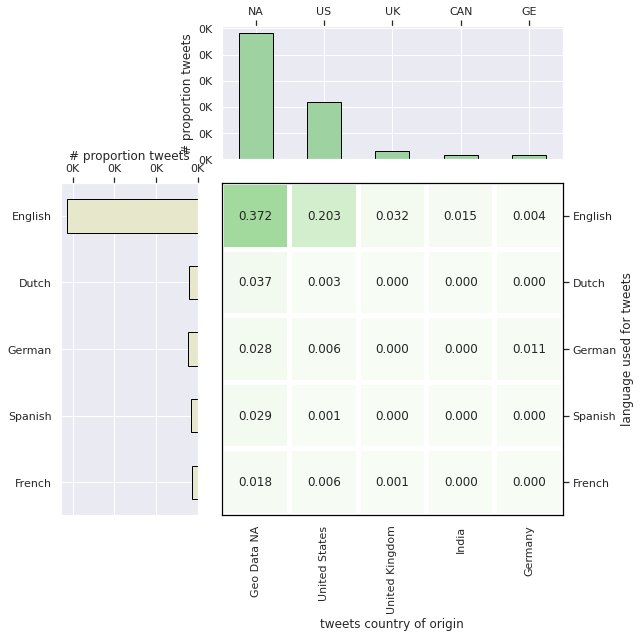

In [ ]:
visualize_heatmap(langXtab, langslst, countrylst, heatmap2_args, 'tweets country of origin', 'language used for tweets', ('English', 'Dutch', 'German','Spanish','French'), barcolors, barstyle,
                      formatterK1, ('NA', 'US', 'UK', 'CAN', 'GE', 'FRA'), '', '# proportion tweets', ('French', 'Spanish', 'German', 'Dutch', 'English'), '# proportion tweets', '')

In [ ]:
# Obtain tweets only from data that has Geo Data from the US
text1=df_biden.loc[df_biden['country'] == 'United States of America']['tweet']
text2=df_trump.loc[df_trump['country'] == 'United States of America']['tweet']

In [ ]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
words1 = custom_lemmatize(''.join(str(text1.apply(clean_tweet).tolist())))
words2 = custom_lemmatize(''.join(str(text2.apply(clean_tweet).tolist())))

biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

# Visualize the bi, tri-gram of all USA tweets

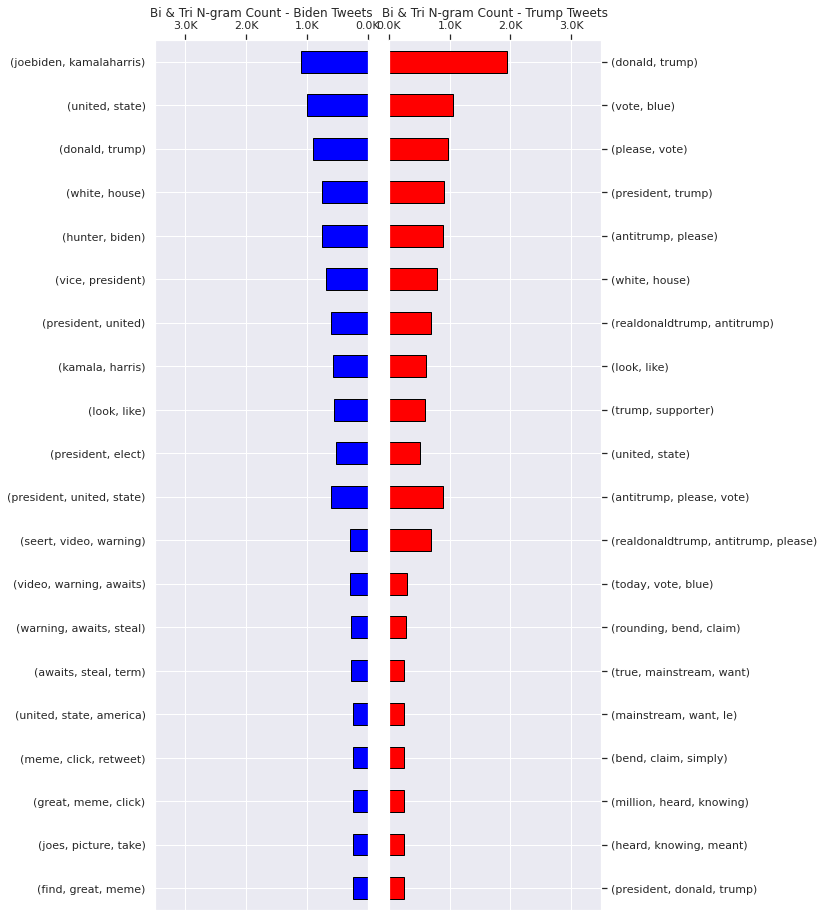

In [ ]:
generate_ngram(biden_ngrams, trump_ngrams, "Bi & Tri N-gram Count - Biden Tweets", "Bi & Tri N-gram Count - Trump Tweets", 1)

# Word cloud of Biden tweets

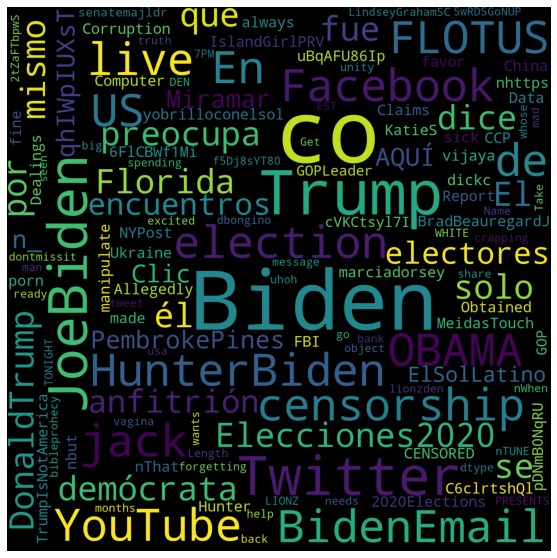

In [ ]:
# Plot the word cloud of Biden tweets
generate_word_cloud(stop_words, text1)

# Word cloud of Trump tweets

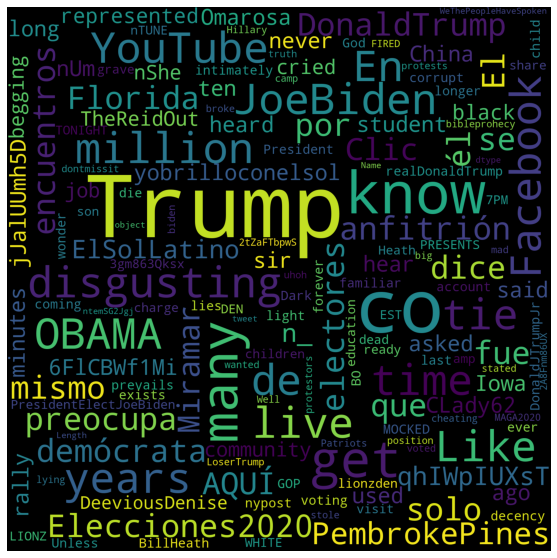

In [ ]:
# Plot the word cloud of Trump tweets
generate_word_cloud(stop_words, text2)

# Add 2020 English language tweets to training dataset for variety

In [ ]:
# Add randomly sampled 10,0000 Biden tweets, detect language, add those in English to training corpus
df_biden_english_tweets= df_biden.sample(n=10000).copy()
df_biden_english_tweets['lang'] = df_biden_english_tweets['preprocessed_tweet'].apply(detect_tweetlang)

In [ ]:
df_biden_english_tweets[df_biden_english_tweets['lang']=="en"].shape

(6183, 23)

In [ ]:
# Add randomly sampled 10,0000 Trump tweets, detect language, add those in English to training corpus
df_trump_english_tweets= df_trump.sample(n=10000).copy()
df_trump_english_tweets['lang'] = df_trump_english_tweets['preprocessed_tweet'].apply(detect_tweetlang)

In [ ]:
df_trump_english_tweets[df_trump_english_tweets['lang']=="en"].shape

(6793, 23)

In [ ]:
# Merge English language tweets from 2020 cycle
df_english_tweets_2020 = pd.concat([df_biden_english_tweets, df_trump_english_tweets])
df_english_tweets_2020.reset_index(drop=True, inplace=True)

# Perform Sentiment Analysis on 2020 English language tweets

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [ ]:
sid = SentimentIntensityAnalyzer()
df_english_tweets_2020['sentiment_score']=sentiment(df_english_tweets_2020['preprocessed_tweet'])
df_english_tweets_2020['compound']  = df_english_tweets_2020['sentiment_score'].apply(lambda score_dict: score_dict['compound'])
df_english_tweets_2020['type']  = df_english_tweets_2020['compound'].apply(lambda x: 'real' if x > 0.05 else 'fake')

In [ ]:
df_english_tweets_2020[df_english_tweets_2020['type']=="real"].shape

(6324, 26)

In [ ]:
df_english_tweets_2020[df_english_tweets_2020['type']=="fake"].shape

(13676, 26)

In [ ]:
all_news

# Write preprocessed, merged real and fake news to csv

In [ ]:
# Write merged real, fake news to csv
all_news.to_csv(r'/content/drive/My Drive/255/datasets/all_news_preprocessed.csv', index = False, header=True)

# Write preprocessed Biden, Trump tweets to csv

In [ ]:
# Prune unwanted columns in biden preprocessed tweets
df_biden_preprocessed_tweets = df_biden[['created_at', 'tweet', 'preprocessed_tweet', 'likes', 'retweet_count']]
df_biden_preprocessed_tweets.dropna(inplace=True)
df_biden_preprocessed_tweets.reset_index(drop=True, inplace=True)
df_biden_preprocessed_tweets['type'] = ' '
df_biden_preprocessed_tweets.columns = ['created_at', 'tweet', 'preprocessed_tweet', 'likes', 'retweet_count', 'type']
df_biden_preprocessed_tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,created_at,tweet,preprocessed_tweet,likes,retweet_count,type
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi,0.0,0.0,
1,2020-10-15 00:00:18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,hunterbiden hunterbidenemails joebiden joebidenmuststepdown enmxwvepm,0.0,0.0,
2,2020-10-15 00:00:20,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,this is how biden made his trumpisnotamerica ip,0.0,0.0,
3,2020-10-15 00:00:21,@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden,watching and setting dvr let give him bonus ratings joebiden,0.0,0.0,
4,2020-10-15 00:00:22,#censorship #HunterBiden #Biden #BidenEmails #BidenEmail #Corruption https://t.co/C6clrtshQl,censorship hunterbiden biden bidenemails bidenemail corruption clrtshql,1.0,0.0,
...,...,...,...,...,...,...
776881,2020-11-08 23:59:38,Stop laying @CNN !\n#Paris and #London dont give a fuck about #biden and we Know that we have to wait until the end of élections #trump maybe the POTUS again 😂! https://t.co/HIPRlVxEWX,stop laying paris and london dont give fuck about biden and we know that we have to wait until the end of élections trump maybe the potus again,0.0,0.0,
776882,2020-11-08 23:59:38,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του 😱 #Biden https://t.co/DUqGJPzPxP,ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του biden,0.0,0.0,
776883,2020-11-08 23:59:41,"L'OTAN va sortir de sa léthargie et redevenir le cheval de Troie des intérêts américains. Quelle bonne nouvelle pour l'Europe : vassale elle était, vassale elle restera. Ceux qui saluent la victoire de #Biden sont des crétins finis. #Election2020 https://t.co/fLL97rXH9A",otan va sortir de sa léthargie et redevenir le cheval de troie des intérêts américains quelle bonne nouvelle pour europe vassale elle était vassale elle restera ceux qui saluent la victoire de biden sont des crétins finis election rxh,48.0,14.0,
776884,2020-11-08 23:59:52,"🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice per #JillBiden,mia cugina. La vorrei invitare[..] per conoscerci. È una grandissima emozione[..]’\nA parlare è Caterina Giacoppo,lontana cugina di #JillJacobs,la nuova First Lady,la moglie di #Biden\n(via @Adnkronos)https://t.co/P8ksr3tAKo",congiuntifuoriregione sono felice per jillbiden mia cugina la vorrei invitare per conoscerci è una grandissima emozione parlare è caterina giacoppo lontana cugina di jilljacobs la nuova first lady la moglie di biden via ksr tako,1.0,1.0,


In [ ]:
df_biden_preprocessed_tweets.isnull().sum()

created_at            0
tweet                 0
preprocessed_tweet    0
type                  0
dtype: int64

In [ ]:
# Prune unwanted columns in trump preprocessed tweets
df_trump_preprocessed_tweets = df_trump[['created_at', 'tweet', 'preprocessed_tweet', 'likes', 'retweet_count']]
df_trump_preprocessed_tweets.dropna(inplace=True)
df_trump_preprocessed_tweets.reset_index(drop=True, inplace=True)
df_trump_preprocessed_tweets['type'] = ' '
df_trump_preprocessed_tweets.columns = ['created_at', 'tweet', 'preprocessed_tweet','likes', 'retweet_count', 'type']
df_trump_preprocessed_tweets

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,created_at,tweet,preprocessed_tweet,likes,retweet_count,type
0,2020-10-15 00:00:01,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi,0.0,0.0,
1,2020-10-15 00:00:01,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",usa trump contro facebook twitter coprono biden donaldtrump ceurhe vp jidljoon,26.0,9.0,
2,2020-10-15 00:00:02,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",trump as student used to hear for years for ten years heard china in and we have and they don know how many we have and asked them how many do we have and they said sir we don know but we have millions like million um what,2.0,1.0,
3,2020-10-15 00:00:02,2 hours since last tweet from #Trump! Maybe he is VERY busy. Tremendously busy.,hours since last tweet from trump maybe he is very busy tremendously busy,0.0,0.0,
4,2020-10-15 00:00:08,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,you get tie and you get tie trump rally iowa,4.0,3.0,
...,...,...,...,...,...,...
970914,2020-11-08 23:59:43,"@PelleX @Mikerger @spiegelbilderz_ @BertiFranz @Georg_Pazderski Sagten Sie nicht Sie wären kein Sozi!?\n\nWas ist so schwer daran zu verstehen, dass das Lohnniveau wärend seiner Präsidentschaft gestiegen ist!?\n\nIhnen sind vielleicht die 100000de Jobs egal aber den Amerikanern haben die gut getan.\n\n#Trump",sagten sie nicht sie wären kein sozi was ist so schwer daran zu verstehen dass das lohnniveau wärend seiner präsidentschaft gestiegen ist ihnen sind vielleicht die de jobs egal aber den amerikanern haben die gut getan trump,0.0,0.0,
970915,2020-11-08 23:59:48,JOE BIDEN WHY JOE BIDEN DID WINNED ?? TRUMP TRUMP TRUMP IS WAY BETTER YOU IDIOTS IM GOING TO LEAVE THIS COUNTRY #Trump,joe biden why joe biden did winned trump trump trump is way better you idiots im going to leave this country trump,4.0,0.0,
970916,2020-11-08 23:59:53,"#AfD|ler reagieren panisch bis hysterisch auf die Abwahl von #Trump.\n\nFür sie ist er die Inkarnation ihrer feuchtesten Träume, mit der Kombination aus Dummheit und Rassismus ein Maximum an Macht und Schutz vor dem Zugriff von Finanz- und Sicherheitsbehörden zu erreichen. https://t.co/C2qVs3hln4",afd ler reagieren panisch bis hysterisch auf die abwahl von trump für sie ist er die inkarnation ihrer feuchtesten träume mit der kombination aus dummheit und rassismus ein maximum an macht und schutz vor dem zugriff von finanz und sicherheitsbehörden zu erreichen qvs hln,25.0,4.0,
970917,2020-11-08 23:59:54,"@sammelbis1998 @iheartmindy @bnorthg First, you would need to compare that to previous elections since many people don’t vote the whole ticket every year. Second, you have to show your source for your data. Third, you need to know that millions of people just wanted to vote fascist #Trump out.",first you would need to compare that to previous elections since many people don vote the whole ticket every year second you have to show your source for your data third you need to know that millions of people just wanted to vote fascist trump out,0.0,0.0,


In [ ]:
df_trump_preprocessed_tweets.isnull().sum()

created_at            0
tweet                 0
preprocessed_tweet    0
type                  0
dtype: int64

In [ ]:
# Write Biden preprocessed tweets to csv
df_biden_preprocessed_tweets.to_csv(r'/content/drive/My Drive/255/datasets/biden_tweets_preprocessed.csv', index = False, header=True)

In [ ]:
# Write Trump preprocessed tweets to csv
df_trump_preprocessed_tweets.to_csv(r'/content/drive/My Drive/255/datasets/trump_tweets_preprocessed.csv', index = False, header=True)